
# Feature agglomeration vs. univariate selection

This example compares 2 dimensionality reduction strategies:

- univariate feature selection with Anova

- feature agglomeration with Ward hierarchical clustering

Both methods are compared in a regression problem using
a BayesianRidge as supervised estimator.


In [1]:
# Author: Alexandre Gramfort <alexandre.gramfort@inria.fr>
# License: BSD 3 clause

In [2]:
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from joblib import Memory
from scipy import linalg, ndimage

from sklearn import feature_selection
from sklearn.cluster import FeatureAgglomeration
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline

Set parameters



In [3]:
n_samples = 200
size = 40  # image size
roi_size = 15
snr = 5.0
np.random.seed(0)

Generate data



In [4]:
coef = np.zeros((size, size))
coef[0:roi_size, 0:roi_size] = -1.0
coef[-roi_size:, -roi_size:] = 1.0

X = np.random.randn(n_samples, size**2)
for x in X:  # smooth data
    x[:] = ndimage.gaussian_filter(x.reshape(size, size), sigma=1.0).ravel()
X -= X.mean(axis=0)
X /= X.std(axis=0)

y = np.dot(X, coef.ravel())

add noise



In [5]:
noise = np.random.randn(y.shape[0])
noise_coef = (linalg.norm(y, 2) / np.exp(snr / 20.0)) / linalg.norm(noise, 2)
y += noise_coef * noise

Compute the coefs of a Bayesian Ridge with GridSearch



Ward agglomeration followed by BayesianRidge



In [13]:
cv = KFold(2)  # cross-validation generator for model selection
ridge = BayesianRidge()
cachedir = tempfile.mkdtemp()
mem = Memory(location=cachedir, verbose=1)
connectivity = grid_to_graph(n_x=size, n_y=size)
ward = FeatureAgglomeration(n_clusters=10, connectivity=connectivity, memory=mem)
clf = Pipeline([("ward", ward), ("ridge", ridge)])
# Select the optimal number of parcels with grid search
clf = GridSearchCV(clf, {"ward__n_clusters": [10, 20, 30]}, n_jobs=1, cv=cv)
clf.fit(X, y)  # set the best parameters
coef_ = clf.best_estimator_.steps[-1][1].coef_
coef_ = clf.best_estimator_.steps[0][1].inverse_transform(coef_)
coef_agglomeration_ = coef_.reshape(size, size)

________________________________________________________________________________
[Memory] Calling sklearn.cluster._agglomerative.ward_tree...
ward_tree(array([[-0.451933, ..., -0.675318],
       ...,
       [ 0.275706, ..., -1.085711]]), connectivity=<1600x1600 sparse matrix of type '<class 'numpy.int32'>'
	with 7840 stored elements in COOrdinate format>, n_clusters=None, return_distance=False)
________________________________________________________ward_tree - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.cluster._agglomerative.ward_tree...
ward_tree(array([[ 0.905206, ...,  0.161245],
       ...,
       [-0.849835, ..., -1.091621]]), connectivity=<1600x1600 sparse matrix of type '<class 'numpy.int32'>'
	with 7840 stored elements in COOrdinate format>, n_clusters=None, return_distance=False)
________________________________________________________ward_tree - 0.0s, 0.0min
__________________________________________

### Step 1: Connectivity Matrix with `grid_to_graph`

**Function**: `grid_to_graph(n_x=size, n_y=size)`

**Purpose**: Creates a connectivity matrix that represents the grid structure of the features. This ensures that the clustering algorithm considers the spatial structure of the data.

**Math**:
- Constructs a graph where each node represents a feature.
- Edges are created between neighboring nodes based on the grid structure.

**Main Args**:
- `n_x`: Number of nodes in the x-direction (width of the grid).
- `n_y`: Number of nodes in the y-direction (height of the grid).

**Explanation**:
- The connectivity matrix is used to define the neighborhood relationships between features in a grid. This spatial information is critical for methods like agglomerative clustering, which can leverage the structure to produce more meaningful clusters.


### Step 2: Feature Agglomeration with `FeatureAgglomeration`

**Function**: `ward = FeatureAgglomeration(n_clusters=10, connectivity=connectivity, memory=mem)`

**Purpose**: Reduces the dimensionality of the feature space by clustering similar features together. The `connectivity` parameter ensures that only neighboring features in the grid are clustered together.

**Math**:
- **Hierarchical Clustering**: Uses Ward's method to minimize variance within clusters.
- **Distance Calculation**: Considers the connectivity matrix to enforce spatial constraints.

**Main Args**:
- `n_clusters`: Number of clusters to find.
- `connectivity`: Connectivity matrix that defines neighboring relationships.
- `memory`: Used to cache the tree computation for faster processing.

**Explanation**:
- Feature agglomeration clusters features instead of samples, reducing the feature space's dimensionality. This can be especially useful when dealing with high-dimensional data, as it groups similar features together, creating a more manageable set of features.


### Step 3: Caching Intermediate Results

**Parameter**: `memory=mem`

**Purpose**: Uses caching to store intermediate computations to disk, avoiding redundant calculations and speeding up the process.

**Explanation**:
- The `memory` parameter is set to a caching directory (e.g., `mem = Memory(cachedir='/path/to/cache')`).
- When caching is enabled, intermediate results from the feature agglomeration step are saved in the specified cache directory.
- If the same computation is needed again (e.g., during cross-validation), the cached results are used, significantly speeding up the process.

**Main Args**:
- `cachedir`: Directory where the cache is stored.
- `verbose`: Level of verbosity for logging.

**Example**:
```python
from joblib import Memory
mem = Memory(cachedir='/path/to/cache', verbose=1)



### Step 4: Pipeline Creation

**Function**: `clf = Pipeline([("ward", ward), ("ridge", ridge)])`

**Purpose**: Combines feature agglomeration and ridge regression into a single pipeline.

**Math**:
- **Feature Transformation**: Applies hierarchical clustering to transform the features.
- **Regression**: Performs ridge regression on the transformed feature space.

**Main Args**:
- `steps`: List of (name, transform) tuples that are chained together.

**Explanation**:
- The pipeline ensures that the feature transformation (agglomeration) and the regression model are applied sequentially in a streamlined manner. This simplifies the process of fitting and predicting with the combined model.


In [27]:
coef_ = clf.best_estimator_.steps[-1][1].coef_
coef_.shape ## 20, so 20 clusters have been created, instaerd of the 16000 feature sinitially

clf.best_estimator_.steps[0][1].inverse_transform(coef_)

array([-120.37167244, -120.37167244, -120.37167244, ...,   75.3695938 ,
         75.3695938 ,   75.3695938 ])

Anova univariate feature selection followed by BayesianRidge



In [28]:
f_regression = mem.cache(feature_selection.f_regression)  # caching function
anova = feature_selection.SelectPercentile(f_regression)
clf = Pipeline([("anova", anova), ("ridge", ridge)])
# Select the optimal percentage of features with grid search
clf = GridSearchCV(clf, {"anova__percentile": [5, 10, 20]}, cv=cv)
clf.fit(X, y)  # set the best parameters
coef_ = clf.best_estimator_.steps[-1][1].coef_
coef_ = clf.best_estimator_.steps[0][1].inverse_transform(coef_.reshape(1, -1))
coef_selection_ = coef_.reshape(size, size)

________________________________________________________________________________
[Memory] Calling sklearn.feature_selection._univariate_selection.f_regression...
f_regression(array([[-0.451933, ...,  0.275706],
       ...,
       [-0.675318, ..., -1.085711]]), 
array([ 25.267703, ..., -25.026711]))
_____________________________________________________f_regression - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.feature_selection._univariate_selection.f_regression...
f_regression(array([[ 0.905206, ..., -0.849835],
       ...,
       [ 0.161245, ..., -1.091621]]), 
array([ -27.447268, ..., -112.638768]))
_____________________________________________________f_regression - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.feature_selection._univariate_selection.f_regression...
f_regression(array([[ 0.905206, ..., -0.849835],
       ...,
       [-0.67

### Feature Selection Using ANOVA

#### Overview

Feature selection is a crucial step in the machine learning pipeline, where the goal is to select the most relevant features for building a predictive model. Here, we use the ANOVA F-test to select features based on their relationship with the target variable.

#### Math Behind ANOVA F-Test

- **ANOVA (Analysis of Variance)**: This statistical method assesses whether the means of different groups are significantly different from each other.
- **F-Test**: In this context, the F-test compares the variance between the groups (explained variance) to the variance within the groups (unexplained variance).

The F-value is calculated as:
$\ F = \frac{\text{variance between groups}}{\text{variance within groups}} $

For each feature:
$\ F_j = \frac{\sum_{k=1}^{K} n_k (\bar{x}_{k,j} - \bar{x}_j)^2}{\sum_{k=1}^{K} \sum_{i=1}^{n_k} (x_{i,j} - \bar{x}_{k,j})^2} $

Where:
- $\ K $ is the number of groups.
- $\ n_k $ is the number of samples in group $\ k $.
- $\ \bar{x}_{k,j} $ is the mean of feature $\ j $ in group $\ k $.
- $\ \bar{x}_j $ is the overall mean of feature $\ j $.
- $\ x_{i,j} $ is the value of feature $\ j $ for sample $\ i $.

#### Intuition

The intuition behind using the ANOVA F-test for feature selection is to determine which features have the strongest linear relationship with the target variable. Features with higher F-values are considered more important because they explain a larger proportion of the variance in the target variable.

#### How It Selects Features

- **Calculation of F-values**: For each feature, the F-value is computed as described above.
- **Ranking**: Features are ranked based on their F-values.
- **Selection**: A specified percentage of features with the highest F-values are selected. Features not selected are effectively reduced in importance, often set to zero or ignored in further modeling.

#### Main Arguments

- `score_func`: The scoring function used to evaluate the features. For ANOVA F-test, this is typically `feature_selection.f_regression`. It calculates the F-statistic for each feature based on a simple linear regression model.
- `percentile`: The percentage of top features to retain. For example, if `percentile=10`, only the top 10% of features based on their F-values will be selected.

#### Advantages

- **Simplicity**: The ANOVA F-test is easy to compute and understand.
- **Efficiency**: It is computationally efficient, making it suitable for high-dimensional data.
- **Relevance**: By selecting features based on their statistical significance, we can improve the performance of the model by focusing on the most informative features.

#### Disadvantages

- **Univariate**: ANOVA F-test considers each feature independently, ignoring potential interactions between features.
- **Linear Assumption**: Assumes a linear relationship between each feature and the target variable, which may not always hold true in practice.


In [32]:
coef_selection_  ### on voit bien la sparsité

array([[-2.01025718,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.29924318, -1.46482568,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.24701165, -2.0628664 , -1.68655819, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

Inverse the transformation to plot the results on an image



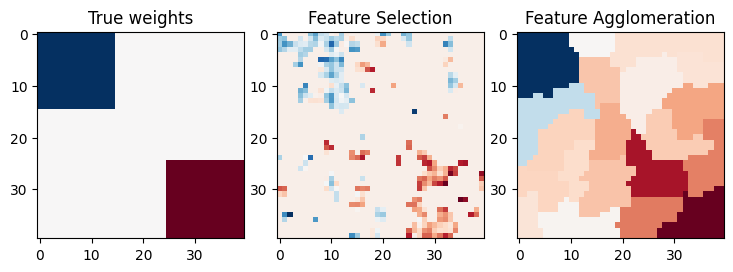

In [29]:
plt.close("all")
plt.figure(figsize=(7.3, 2.7))
plt.subplot(1, 3, 1)
plt.imshow(coef, interpolation="nearest", cmap=plt.cm.RdBu_r)
plt.title("True weights")
plt.subplot(1, 3, 2)
plt.imshow(coef_selection_, interpolation="nearest", cmap=plt.cm.RdBu_r)
plt.title("Feature Selection")
plt.subplot(1, 3, 3)
plt.imshow(coef_agglomeration_, interpolation="nearest", cmap=plt.cm.RdBu_r)
plt.title("Feature Agglomeration")
plt.subplots_adjust(0.04, 0.0, 0.98, 0.94, 0.16, 0.26)
plt.show()

on voit bienq ue en faisant de la feature agglomeration on a plus que 10 clusters de features au lieu des tonnes sur juste un Feature selection

Attempt to remove the temporary cachedir, but don't worry if it fails



In [30]:
shutil.rmtree(cachedir, ignore_errors=True)